In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash 
pwd

/content


cd /content/drive/My\ Drive/Transformer-master/
変更
cd /content/drive/My\ Drive/Colab\ Notebooks/Transformer 

In [ ]:
cd /content/drive/My\ Drive/Colab\ Notebooks/Transformer

/content/drive/My Drive/Colab Notebooks/Transformer


# ライブラリ読み込み

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.6
!pip install japanize_matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.7)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.12)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+ma

In [ ]:
import numpy as np
import os
import time
import MeCab

import preprocess_utils
import model
import weight_utils

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

2.4.0


# 日英翻訳データ ダウンロード

In [ ]:
!wget http://www.manythings.org/anki/jpn-eng.zip
!unzip ./jpn-eng.zip

# データ読み込み

 `corpus_path = './jpn.txt'` -> `corpus_path = './DATA/kesen3_ex.tsv'`

In [ ]:
dataset = preprocess_utils.CreateData(
    corpus_path = './DATA/kesen3_ex.tsv',
    do_shuffle=True,
    seed_value=123,
    split_percent=0.95 # 学習データの割合
)

train_source, train_target, test_source, test_target, train_licence, test_licence = dataset.split_data()

print('**** Amount of data ****')
print('train_source： ', len(train_source))
print('train_target： ', len(train_target))
print('test_source： ', len(test_source))
print('test_target： ', len(test_target))
print('\n')
print('**** Train data example ****')
print('Source Example： ', train_source[0])
print('Target Example： ', train_target[0])
print('Licence： ', train_licence[0])
print('\n')
print('**** Test data example ****')
print('Source Example： ', test_source[0])
print('Target Example： ', test_target[0])
print('Licence： ', test_licence[0])

**** Amount of data ****
train_source：  5021
train_target：  5021
test_source：  264
test_target：  264


**** Train data example ****
Source Example：  イロメイショウ
Target Example：  ロバタ
Licence：  気仙沼市


**** Test data example ****
Source Example：  ライチチオヤニ
Target Example：  クル
Licence：  気仙沼市


# 前処理

In [ ]:
BATCH_SIZE = 64 # バッチサイズ
MAX_LENGTH = 60 # シーケンスの長さ
USE_TPU = False # TPUを使うか
BUFFER_SIZE = 50000

In [ ]:
train_dataset = preprocess_utils.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = train_source,
    target_data = train_target,
    max_length = MAX_LENGTH,
    batch_size = BATCH_SIZE,
    test_flag = False,
    train_dataset = None,
)

train_dataset.preprocess_data()

In [ ]:
test_dataset = preprocess_utils.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = test_source,
    target_data = test_target,
    max_length = MAX_LENGTH,
    batch_size = BATCH_SIZE,
    test_flag = True,
    train_dataset = train_dataset
)

test_dataset.preprocess_data()

# バッチ作成

In [ ]:
if USE_TPU:
  tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
  tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
  tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)    
  strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)

trainset = tf.data.Dataset.from_tensor_slices((train_dataset.source_vector, train_dataset.target_vector))
trainset = trainset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

if USE_TPU:
  trainset = strategy.experimental_distribute_dataset(trainset)

In [ ]:
if USE_TPU:
  PREDICT_BATCH_SIZE = 8
  testset = tf.data.Dataset.from_tensor_slices((test_dataset.source_vector, test_dataset.target_vector))
  testset = testset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=50000).batch(PREDICT_BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  testset = testset.take(1)
  testset = strategy.experimental_distribute_dataset(testset)

# モデル定義

In [ ]:
num_layers=4 # レイヤー数
d_model=64 # 中間層の次元数
num_heads=4 # Multi Head Attentionのヘッド数
dff=2048 # Feed Forward Networkの次元数
dropout_rate = 0.1 # ドロップアウト率

source_vocab_size = max(train_dataset.source_token.values()) + 1 # source文の語彙数
target_vocab_size = max(train_dataset.target_token.values()) + 1 # target文の語彙数

In [ ]:
# 重み初期化
def initialize_weight(checkpoint_path, optimizer, transformer, max_length, batch_size, use_tpu=False):

  if os.path.exists(checkpoint_path+'.pkl'):
    if use_tpu:
      number_of_tpu_cores = tpu_cluster_resolver.num_accelerators()['TPU']
      initialize_source, initialize_target = [[1]*max_length]*number_of_tpu_cores, [[1]*max_length]*number_of_tpu_cores
      initialize_set = tf.data.Dataset.from_tensor_slices((initialize_source, initialize_target))
      initialize_set = initialize_set.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))
          ).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size).prefetch(
              buffer_size=tf.data.experimental.AUTOTUNE
          )
      initialize_set = strategy.experimental_distribute_dataset(initialize_set)

      for inp, tar in initialize_set:
        distributed_train_step(inp, tar)

    else:
      initialize_set = tf.ones([batch_size, max_length], tf.int64)
      train_step(initialize_set, initialize_set)
    
    try:
      weight_utils.load_weights_from_pickle(checkpoint_path, optimizer, transformer)
    except:
      print('Failed to load checkpoints.')

  else:
    print('No available checkpoints.')

# 予測

checkpoints/gpu/model -> /checkpoints_EX/gpu/model

In [ ]:
# Transformer
transformer = model.Transformer(num_layers, d_model, num_heads, dff,
                          source_vocab_size, target_vocab_size, 
                          pe_input=source_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

# Learning Rate
learning_rate = model.CustomSchedule(d_model)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

# Loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Loss Function
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# Checkpoint
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Transformer/checkpoints_EX/gpu/model" #/checkpoints/gpu/model

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

# Initialize Weight
initialize_weight(checkpoint_path, optimizer, transformer, MAX_LENGTH, BATCH_SIZE, use_tpu=USE_TPU)

Load checkpoints successfully.


In [ ]:
def predict(input_vec):

  encoder_input = np.array([input_vec])

  decoder_input = [max(train_dataset.target_token.values())-2]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(train_dataset.max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(
        encoder_input, output)


    predictions, attention_weights = transformer(encoder_input, 
                                                  output,
                                                  False,
                                                  enc_padding_mask,
                                                  combined_mask,
                                                  dec_padding_mask)
    
    predictions = predictions[: ,-1:, :]

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if predicted_id == max(train_dataset.target_token.values())-1:
      return tf.squeeze(output, axis=0), attention_weights
    
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, input_source, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tf.cast(input_source, tf.int64)
  attention = attention[layer][0,:, :, :len(input_source)]
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    tmp_list = []
    for i in sentence:
      try:
        tmp_list.append(train_dataset.source_index[i.numpy()])
      except:
        pass

    ax.set_xticklabels(tmp_list, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([train_dataset.target_index[i.numpy()] for i in result 
                        if i < max(train_dataset.target_token.values()) - 1], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

Input: <start> ライチチオヤニ <end>
Output: クル


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


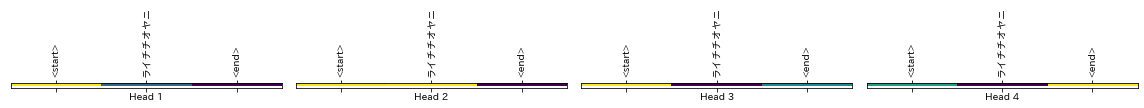

In [ ]:
# 翻訳
n = 0# 任意のテストデータを指定
print("Input:", ' '.join([train_dataset.source_index[i] for i in test_dataset.source_vector[n][:np.argmax(test_dataset.source_vector[n], 0)+1]]))

result, attention = predict(test_dataset.source_vector[n][:np.argmax(test_dataset.source_vector[n], 0)+1])
txt = ""

for i in result[1:]:
  txt+=train_dataset.target_index[i.numpy()]
print("Output:", txt)

# Attention Weightをプロット
plot_attention_weights(attention, test_dataset.source_vector[n][:np.argmax(test_dataset.source_vector[n], 0)+1], result[1:], "decoder_layer4_block2")